In [1]:
import bilby
import numpy as np
from bilby.core.utils import random

/work/submit/kyoon/miniforge3/envs/ssm/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
random.seed(123)

In [3]:
data = random.rng.normal(loc=0, scale=1, size=1000)

In [4]:
class SimpleGaussianLikelihood(bilby.Likelihood):
    def __init__(self, data):
        """
        A very simple Gaussian likelihood

        Parameters
        ----------
        data: array_like
            The data to analyse
        """
        super().__init__(parameters={"mu": None, "sigma": None})
        self.data = data
        self.N = len(data)


    def log_likelihood(self):
        mu = self.parameters["mu"]
        sigma = self.parameters["sigma"]
        res = self.data - mu
        return -0.5 * (
            np.sum((res / sigma) ** 2) + self.N * np.log(2 * np.pi * sigma**2)
        )

In [5]:
likelihood = SimpleGaussianLikelihood(data)
priors = dict(
    mu = bilby.core.prior.Uniform(0, 5, name='mu'),
    sigma = bilby.core.prior.Uniform(0, 10, name='sigma')
)

12:50 bilby INFO    : Running for label 'simple_gaussian', output will be saved to 'outdir'
12:50 bilby INFO    : Analysis priors:
12:50 bilby INFO    : mu=Uniform(minimum=0, maximum=5, name='mu', latex_label='mu', unit=None, boundary=None)
12:50 bilby INFO    : sigma=Uniform(minimum=0, maximum=10, name='sigma', latex_label='sigma', unit=None, boundary=None)
12:50 bilby INFO    : Analysis likelihood class: <class '__main__.SimpleGaussianLikelihood'>
12:50 bilby INFO    : Analysis likelihood noise evidence: nan
12:50 bilby INFO    : Single likelihood evaluation took 4.031e-05 s
12:50 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 1000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'gradient': None, 'grad_args': None,

12045it [00:16, 601.51it/s, bound:250 nc: 20 ncall:1.9e+05 eff:6.4% logz=-1433.37+/-0.09 dlogz:0.105>0.1]  

12:50 bilby INFO    : Written checkpoint file outdir/simple_gaussian_resume.pickle
/work/submit/kyoon/miniforge3/envs/ssm/lib/python3.10/site-packages/dynesty/plotting.py:318: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


12091it [00:26, 459.79it/s, bound:251 nc:  1 ncall:1.9e+05 eff:6.9% logz=-1433.27+/-0.09 dlogz:9.53e-05>0.1]

12:50 bilby INFO    : Rejection sampling nested samples to obtain 2533 posterior samples
12:50 bilby INFO    : Sampling time: 0:00:26.294655


12:50 bilby INFO    : Summary of results:
nsamples: 2533
ln_noise_evidence:    nan
ln_evidence: -1433.269 +/-  0.120
ln_bayes_factor:    nan +/-  0.120



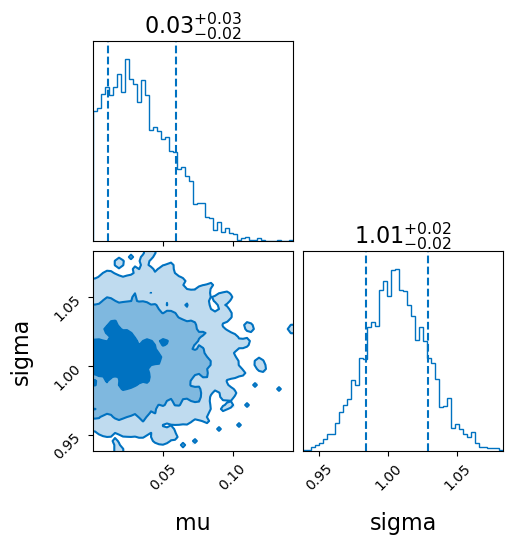

In [6]:
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler='dynesty',
    npoints=1000,
    outdir='outdir',
    label='simple_gaussian'
)
result.plot_corner()

### Damped Harmonic Oscillator Data

Which likelihood to use? Gaussian noise -> Gaussian likelihood.

In [7]:
import torch
from torch.utils.data import DataLoader
from bilby.core.likelihood import GaussianLikelihood
from bilby.core.prior import Uniform

In [8]:
torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

device(type='cpu')

In [9]:
import sys
import os

datatype = 'SHO'
if datatype == 'SHO':
    sys.path.append(os.path.abspath('../ssm_regression'))
    from data_sho import damped_sho_np as func
    from data_sho import DataGenerator
elif datatype == 'SineGaussian':
    from data_sinegaussian import sine_gaussian_np as func
    from data_sinegaussian import DataGenerator

my_func = func

datadir = f'/ceph/submit/data/user/k/kyoon/KYoonStudy/models/{datatype}'
savedir = '/ceph/submit/data/user/k/kyoon/KYoonStudy/fitresults'
modeldir = os.path.join(datadir, 'models')
test_dict = torch.load(os.path.join(datadir, 'test.pt'), map_location=torch.device('cpu'))
test_data = DataGenerator(test_dict)

Using device=device(type='cpu')


/tmp/ipykernel_2869251/690387295.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_dict = torch.load(os.path.join(datadir, 'test.pt'), map_location=torch.device('cpu

In [10]:
test_data_loader = DataLoader(
    test_data, batch_size=1, num_workers=0,
    shuffle=False,
)
t_vals_np = np.linspace(start=-1, stop=10, num=200)

Setup priors.

In [11]:
priors = {}
if datatype=='SHO':
    priors['omega_0'] = Uniform(0.1, 1.9, name='omega_0', latex_label=r'$\omega_0$')
    priors['beta'] = Uniform(0, 0.5, name='beta', latex_label=r'$\beta$')
    injection_parameters = dict(omega_0=1., beta=0.3)
elif datatype=='SineGaussian':
    priors['f_0'] = Uniform(0.1, 1.9, name='f_0', latex_label=r'$f_0$')
    priors['tau'] = Uniform(1., 4., name='tau', latex_label=r'$\tau$')
    injection_parameters = dict(f_0=1., tau=2.5)

Run bilby on a single event.

In [12]:
theta_u0, theta_s0, data_u0, data_s0 = next(iter(test_data_loader))

In [13]:
y = data_u0[0][0].to('cpu')
y_np = y.numpy()

In [14]:
log_l = GaussianLikelihood(t_vals_np, y_np, my_func, sigma=0.4, shift=1)

In [15]:
result = bilby.run_sampler(
    likelihood=log_l, priors=priors, sampler='dynesty',
    nlive=50, npool=4, save=True, clean=True,
    injection_parameters=injection_parameters,
    outdir=savedir,
    label=datatype
)

12:51 bilby INFO    : Running for label 'SHO', output will be saved to '/ceph/submit/data/user/k/kyoon/KYoonStudy/fitresults'
12:51 bilby INFO    : Analysis priors:
12:51 bilby INFO    : omega_0=Uniform(minimum=0.1, maximum=1.9, name='omega_0', latex_label='$\\omega_0$', unit=None, boundary=None)
12:51 bilby INFO    : beta=Uniform(minimum=0, maximum=0.5, name='beta', latex_label='$\\beta$', unit=None, boundary=None)
12:51 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
12:51 bilby INFO    : Analysis likelihood noise evidence: nan
12:51 bilby INFO    : Single likelihood evaluation took 5.321e-05 s
12:51 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 50, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 4, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': N

435it [00:00, 429.94it/s, bound:10 nc: 18 ncall:7.6e+03 eff:5.7% logz=-101.32+/-0.32 dlogz:0.115>0.1]

12:51 bilby INFO    : Written checkpoint file /ceph/submit/data/user/k/kyoon/KYoonStudy/fitresults/SHO_resume.pickle
12:51 bilby INFO    : Written checkpoint file /ceph/submit/data/user/k/kyoon/KYoonStudy/fitresults/SHO_resume.pickle
12:51 bilby INFO    : Starting to close worker pool.
12:51 bilby INFO    : Finished closing worker pool.


441it [00:04, 93.86it/s, bound:10 nc:  1 ncall:7.8e+03 eff:6.3% logz=-101.22+/-0.32 dlogz:0.00187>0.1]

12:51 bilby INFO    : Rejection sampling nested samples to obtain 145 posterior samples
12:51 bilby INFO    : Sampling time: 0:00:04.675858
12:51 bilby INFO    : Summary of results:
nsamples: 145
ln_noise_evidence:    nan
ln_evidence: -101.219 +/-  0.373
ln_bayes_factor:    nan +/-  0.373



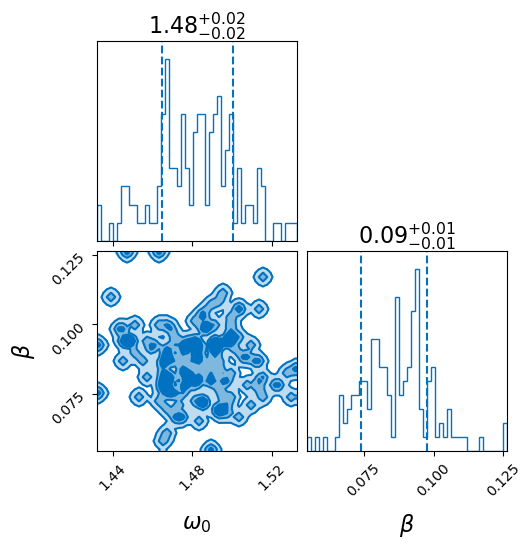

In [16]:
result.plot_corner()

In [17]:
theta_u0

tensor([[[1.4496, 0.0802, 1.0000],
         [1.4496, 0.0802, 1.0000],
         [1.4496, 0.0802, 1.0000],
         [1.4496, 0.0802, 1.0000],
         [1.4496, 0.0802, 1.0000],
         [1.4496, 0.0802, 1.0000],
         [1.4496, 0.0802, 1.0000],
         [1.4496, 0.0802, 1.0000],
         [1.4496, 0.0802, 1.0000],
         [1.4496, 0.0802, 1.0000]]])

What if I don't fix my sigma?

In [18]:
priors_nosigma = {}
priors_nosigma['omega_0'] = Uniform(0.1, 1.9, name='omega_0', latex_label=r'$\omega_0$')
priors_nosigma['beta'] = Uniform(0, 0.5, name='beta', latex_label=r'$\beta$')
priors_nosigma['sigma'] = Uniform(0, 1., name='sigma', latex_label=r'$\sigma$')
injection_parameters_nosigma = dict(omega_0=1., beta=0.3, sigma=0.4)

12:51 bilby INFO    : Running for label 'SHO', output will be saved to '/ceph/submit/data/user/k/kyoon/KYoonStudy/fitresults'
12:51 bilby INFO    : Analysis priors:
12:51 bilby INFO    : omega_0=Uniform(minimum=0.1, maximum=1.9, name='omega_0', latex_label='$\\omega_0$', unit=None, boundary=None)
12:51 bilby INFO    : beta=Uniform(minimum=0, maximum=0.5, name='beta', latex_label='$\\beta$', unit=None, boundary=None)
12:51 bilby INFO    : sigma=Uniform(minimum=0, maximum=1.0, name='sigma', latex_label='$\\sigma$', unit=None, boundary=None)
12:51 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
12:51 bilby INFO    : Analysis likelihood noise evidence: nan
12:51 bilby INFO    : Single likelihood evaluation took 6.706e-05 s
12:51 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 2000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None,

23587it [00:34, 769.60it/s, bound:711 nc: 47 ncall:5.4e+05 eff:4.4% logz=-104.23+/-0.06 dlogz:0.102>0.1]  

12:52 bilby INFO    : Written checkpoint file /ceph/submit/data/user/k/kyoon/KYoonStudy/fitresults/SHO_resume.pickle
12:52 bilby INFO    : Starting to close worker pool.
12:52 bilby INFO    : Finished closing worker pool.


23626it [00:46, 509.52it/s, bound:713 nc:  1 ncall:5.4e+05 eff:4.7% logz=-104.14+/-0.06 dlogz:4.82e-05>0.1]

12:52 bilby INFO    : Rejection sampling nested samples to obtain 6634 posterior samples
12:52 bilby INFO    : Sampling time: 0:00:46.352630


12:52 bilby INFO    : Summary of results:
nsamples: 6634
ln_noise_evidence:    nan
ln_evidence: -104.140 +/-  0.083
ln_bayes_factor:    nan +/-  0.083



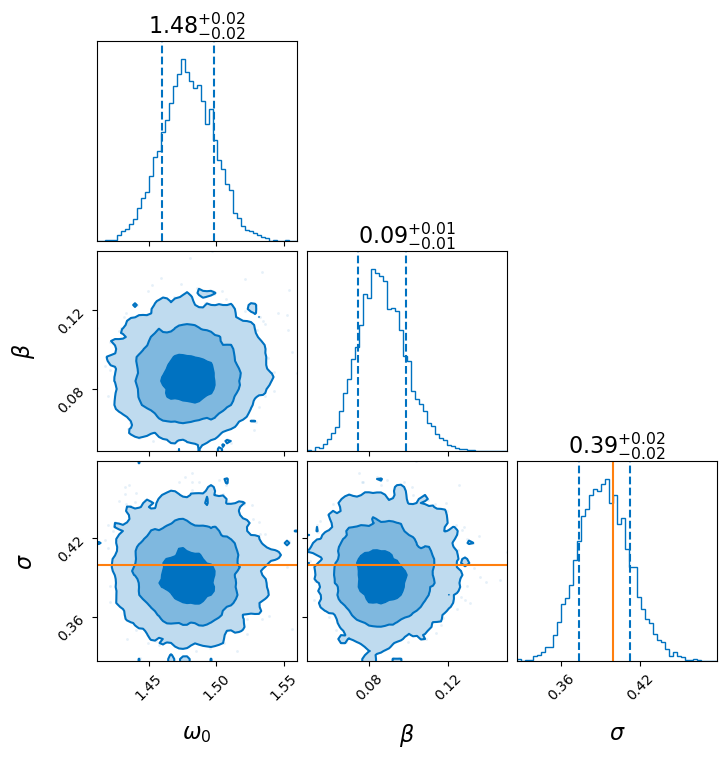

In [19]:
log_l_nosigma = GaussianLikelihood(t_vals_np, y_np, my_func, shift=1)
result_nosigma = bilby.run_sampler(
    likelihood=log_l_nosigma, priors=priors_nosigma, sampler='dynesty',
    nlive=2000, npool=4, save=True, clean=True,
    injection_parameters=injection_parameters_nosigma,
    outdir=savedir,
    label=datatype
)
result_nosigma.plot_corner()

What if I use the truth values for injection parameters?

In [20]:
injection_parameters_truth = dict(omega_0=1.4496, beta=0.0802)

12:52 bilby INFO    : Running for label 'SHO', output will be saved to '/ceph/submit/data/user/k/kyoon/KYoonStudy/fitresults'
12:52 bilby INFO    : Analysis priors:
12:52 bilby INFO    : omega_0=Uniform(minimum=0.1, maximum=1.9, name='omega_0', latex_label='$\\omega_0$', unit=None, boundary=None)
12:52 bilby INFO    : beta=Uniform(minimum=0, maximum=0.5, name='beta', latex_label='$\\beta$', unit=None, boundary=None)
12:52 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
12:52 bilby INFO    : Analysis likelihood noise evidence: nan
12:52 bilby INFO    : Single likelihood evaluation took 5.886e-05 s
12:52 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 2000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 4, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args':

17327it [00:23, 986.16it/s, bound:324 nc:  1 ncall:2.8e+05 eff:6.2% logz=-101.24+/-0.05 dlogz:0.0999>0.1]

12:52 bilby INFO    : Written checkpoint file /ceph/submit/data/user/k/kyoon/KYoonStudy/fitresults/SHO_resume.pickle
12:52 bilby INFO    : Starting to close worker pool.
12:52 bilby INFO    : Finished closing worker pool.


17327it [00:32, 538.86it/s, bound:324 nc:  1 ncall:2.8e+05 eff:7.0% logz=-101.15+/-0.05 dlogz:4.77e-05>0.1]

12:52 bilby INFO    : Rejection sampling nested samples to obtain 5506 posterior samples
12:52 bilby INFO    : Sampling time: 0:00:32.135004


12:52 bilby INFO    : Summary of results:
nsamples: 5506
ln_noise_evidence:    nan
ln_evidence: -101.149 +/-  0.068
ln_bayes_factor:    nan +/-  0.068



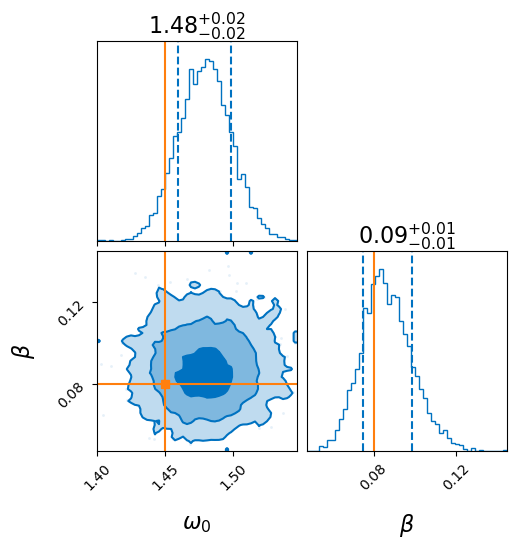

In [21]:
result_injecttruth = bilby.run_sampler(
    likelihood=log_l, priors=priors, sampler='dynesty',
    nlive=2000, npool=4, save=True, clean=True,
    injection_parameters=injection_parameters_truth,
    outdir=savedir,
    label=datatype
)
result_injecttruth.plot_corner()

Now, we need to decide how to split the loading and sampling of bilby mcmc.

In [22]:
test_dict['data_unshifted'].shape

torch.Size([10000, 10, 200])

In [23]:
data_split1 = test_data[0:-1]

In [74]:
test_data

In [69]:
test_data_loader1 = DataLoader(
    data_split1, batch_size=1, num_workers=0,
    shuffle=False,
)

In [71]:
next(iter(test_data_loader1)).shape

torch.Size([1, 9999, 10, 3])

In [24]:
data_split1[2].shape

torch.Size([9999, 10, 200])

In [27]:
result.posterior

,omega_0,beta,log_likelihood,log_prior
0,1.447503,0.126311,-100.179781,0.105361
1,1.463541,0.125437,-99.274736,0.105361
2,1.489350,0.054655,-98.981545,0.105361
3,1.516477,0.116370,-98.961210,0.105361
4,1.530417,0.074705,-98.819712,0.105361
...,...,...,...,...
140,1.476884,0.080999,-94.875051,0.105361
141,1.479285,0.087010,-94.862878,0.105361
142,1.474870,0.083128,-94.856440,0.105361
143,1.479786,0.082657,-94.846229,0.105361


In [33]:
result.posterior.mean()['omega_0']
result.posterior.std()['omega_0']

0.020449330646564057

In [34]:
result.posterior.quantile([0.05, 0.5, 0.95])

,omega_0,beta,log_likelihood,log_prior
0.05,1.446931,0.067637,-98.017669,0.105361
0.50,1.483362,0.086976,-95.572661,0.105361
0.95,1.514712,0.106135,-94.890942,0.105361


In [38]:
result.posterior.describe(percentiles=[0.05,0.25,0.5,0.75,0.95])

,omega_0,beta,log_likelihood,log_prior
count,145.000000,145.000000,145.000000,145.000000
mean,1.482059,0.086451,-95.882434,0.105361
std,0.020449,0.012380,1.028290,0.000000
min,1.432037,0.054655,-100.179781,0.105361
5%,1.446931,0.067637,-98.017669,0.105361
25%,1.467647,0.078308,-96.236603,0.105361
50%,1.483362,0.086976,-95.572661,0.105361
75%,1.494802,0.093801,-95.139352,0.105361
95%,1.514712,0.106135,-94.890942,0.105361
max,1.532637,0.126311,-94.843573,0.105361


In [41]:
desc = result.posterior.describe(percentiles=[0.05, 0.5, 0.95])
stats_df = desc.loc[["mean", "std", "5%", "50%", "95%"]]
stats_df["stat"] = stats_df.index
melted = stats_df.drop(columns="stat").melt(var_name="parameter", value_name="value")

In [57]:
desc = result.posterior.describe(percentiles=[0.05, 0.5, 0.95])
stats_df = desc.loc[["mean", "std", "5%", "50%", "95%"]]
stats_df['stat'] = stats_df.index
stats_df["event_id"] = 0

In [61]:
stats_df

,omega_0,beta,log_likelihood,log_prior,stat,event_id
mean,1.482059,0.086451,-95.882434,0.105361,mean,0
std,0.020449,0.012380,1.028290,0.000000,std,0
5%,1.446931,0.067637,-98.017669,0.105361,5%,0
50%,1.483362,0.086976,-95.572661,0.105361,50%,0
95%,1.514712,0.106135,-94.890942,0.105361,95%,0


In [63]:
stats_df = stats_df.set_index("event_id", append=False)

In [68]:
stats_df.head()

,omega_0,beta,log_likelihood,log_prior,stat
event_id,,,,,
0,1.482059,0.086451,-95.882434,0.105361,mean
0,0.020449,0.012380,1.028290,0.000000,std
0,1.446931,0.067637,-98.017669,0.105361,5%
0,1.483362,0.086976,-95.572661,0.105361,50%
0,1.514712,0.106135,-94.890942,0.105361,95%
